# Reproducing the front page image of the repository

The front page image of the repository is a sampled version of the following image:

![front_page_image](./data/blackjax.png)

Here we show how we can sample from the uniform distribution corresponding to black pixels in the image.  

## Make the image into a numpy array

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

In [10]:
# Load the image
im = mpimg.imread('./data/blackjax.png')

# Convert to mask
im = np.amax(im[:, :, :2], 2) < 0.5

# Convert back to float
im = im.astype(float)
display(im.shape)

(80, 250)

## The sampling procedure

To sample from **BlackJAX**, we form a bridge between the uniform distribution over the full image, corresponding to a 2D domain of size (80, 250) and the uniform distribution over the black pixels.

Formally, this corresponds to a prior distribution $p_0 \sim U([[0, 79]] \times [[0, 249]]$ and a target distribution $p_1(x) \propto \mathbb{1}_{x \in \text{image}}$.

In [11]:
import jax
import jax.numpy as jnp
from datetime import date

rng_key = jax.random.key(int(date.today().strftime("%Y%m%d")))


In [22]:
# Sample from the uniform distribution over the domain
key_init, rng_key = jax.random.split(rng_key)
n_samples = 1_000
INF = 1e6  # A large number
jax_im = jnp.array(im.astype(float))

key_init_xs, key_init_ys = jax.random.split(key_init)
xs_init = jax.random.uniform(key_init_xs, (n_samples,), minval=0, maxval=80)
ys_init = jax.random.randint(key_init_ys, (n_samples,), minval=0, maxval=250)

zs_init = np.stack([xs_init, ys_init], axis=1)


# Set the prior and likelihood
def prior_logpdf(z): return 0.0


# The pdf is uniform, so the logpdf is constant on the domain and negative infinite outside
def log_likelihood(z):
    x, y = z
    # The pixel is black if x, y falls within the image, which means that their integer part is a valid index
    floor_x, floor_y = jnp.floor(x), jnp.floor(y)
    floor_x, floor_y = jnp.astype(floor_x, jnp.int32), jnp.astype(floor_y, jnp.int32)
    out_of_bounds = (floor_x < 0) | (floor_x >= 80) | (floor_y < 0) | (floor_y >= 250)
    value = jax.lax.cond(out_of_bounds,
                         lambda *_: -INF,
                         lambda arg: -INF * (jax_im[arg[0], arg[1]] == 0),
                         operand=(floor_x, floor_y))
    return value



Array(0., dtype=float32, weak_type=True)

## The sampling procedure

We will a RWMH sampler within SMC routine to sample from the target distribution.
For more information we refer to the [documentation](https://blackjax-devs.github.io/sampling-book/algorithms/TemperedSMC.html) specific to SMC


In [51]:
import blackjax
import blackjax.smc.resampling as resampling

# Temperature schedule
n_temperatures = 25
lambda_schedule = np.logspace(-8, 0, n_temperatures)

# The proposal distribution is a random walk with a fixed scale
scale = 0.5  # The scale of the proposal distribution
normal = blackjax.mcmc.random_walk.normal(scale * jnp.ones((2,)))

rw_kernel = blackjax.additive_step_random_walk.build_kernel()
rw_init = blackjax.additive_step_random_walk.init
rw_params = {"random_step": normal}

tempered = blackjax.tempered_smc(
    prior_logpdf,
    log_likelihood,
    rw_kernel,
    rw_init,
    rw_params,
    resampling.systematic,
    num_mcmc_steps=5,
)

initial_smc_state = tempered.init(zs_init)


## Run the SMC sampler

In [52]:
# Define the loop
def smc_inference_loop(loop_key, smc_kernel, init_state, schedule):
    """Run the tempered SMC algorithm.
    """

    def body_fn(carry, lmbda):
        carry_key, state = carry
        carry_key, subkey = jax.random.split(carry_key)
        new_state, info = smc_kernel(subkey, state, lmbda)
        return (rng_key, new_state), (new_state, info)

    _, (all_samples, _) = jax.lax.scan(body_fn, (loop_key, init_state), schedule)

    return all_samples


# Run the SMC sampler
blackjax_samples = smc_inference_loop(rng_key, tempered.step, initial_smc_state, lambda_schedule)

## Plot the samples

In [53]:
weights = np.array(blackjax_samples.weights)
samples = np.array(blackjax_samples.particles)

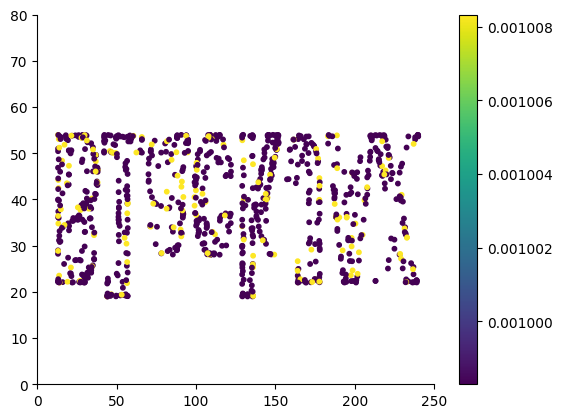

In [57]:
plt.xlim(0, 250)
plt.ylim(0, 80)
plt.scatter(samples[24, :, 1], samples[24, :, 0], c=weights[0], cmap="viridis", s=10)
plt.colorbar()